In [1]:
import msrvxc
import numpy as np
import pickle

import matplotlib.pyplot as plt
from tqdm import tqdm

from astroquery.sdss import SDSS
from astroquery.gaia import Gaia

test


In [2]:
#wvl, raw_values, interp_bosz, interp_bosz_norm = msrvxc.build.build_bosz_grid(wl_range = [3600, 9000])

In [3]:
#with open('grids/interp_bosz_norm.pkl', 'wb') as f:
#    pickle.dump(interp_bosz_norm, f)
#    
#with open('grids/interp_bosz.pkl', 'wb') as f:
#    pickle.dump(interp_bosz, f)
#    
#np.save('grids/wavl.npy',wvl)

In [4]:
with open('grids/interp_bosz.pkl', 'rb') as f:
    interp_bosz = pickle.load(f)
    
with open('grids/interp_bosz_norm.pkl', 'rb') as f:
    interp_bosz_norm = pickle.load(f)
    
wvl = np.load('grids/wavl.npy')

In [5]:
print(len(wvl))

18326


In [6]:
params = (4999.848788360524,
3.812724027560155,
0.4084144628961131,
0.5593886093528815)

print(len(interp_bosz_norm(params)))

18326


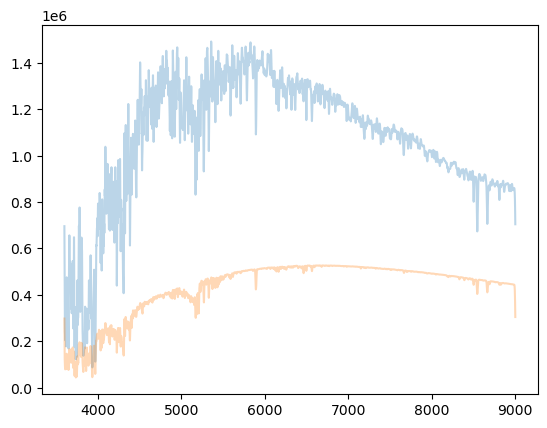

In [7]:


plt.plot(wvl, interp_bosz(params), alpha = 0.3)
plt.plot(wvl, interp_bosz((4213, 4.6, -2.3, 0)), alpha = 0.3)

In [8]:
import msrvxc


#params, rvgrid, cc = msrvxc.fit.fit_rv(interp_bosz_norm, wvl, wvl, interp_bosz_norm((4213, 4.1, -2.3, -40)))



In [9]:
#fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
#samples = sampler.get_chain()
#labels = ["Teff", "logg", "Z", "rv"]
#for i in range(ndim):
#    ax = axes[i]
#    ax.plot(samples[:, :, i], "k", alpha=0.3)
#    ax.set_xlim(0, len(samples))
#    ax.set_ylabel(labels[i])
#    ax.yaxis.set_label_coords(-0.1, 0.5)
#
#axes[-1].set_xlabel("step number");

In [10]:
#flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
#print(flat_samples.shape)

In [11]:
#import corner
#
#fig = corner.corner(
#    flat_samples, labels=labels, truths=[4213, 4.1, -2.3, 0]
#);

In [12]:
#X = np.median(flat_samples,axis=0)
#T, logg, Z, rv = X[:4]
#
#print(T, logg, Z, rv)

In [13]:
from astropy.table import Table, vstack

#catalog = Table.read('../.gravitational-redshift/data/00_raw.fits')
#dat = Table()
#
#dat['sourceid'] = catalog['ms_source_id']

In [25]:
#try:
#    data = Table.read('validation.fits')
#except:
stardats = []
teffs = np.linspace(-200, 200, 100)

for i in tqdm(range(len(teffs)-1)):
    GAIA_ADQL = """SELECT gaia.radial_velocity, gaia.radial_velocity_error, sdss.original_ext_source_id as bestobjid, gaia.rv_template_teff, gaia.rv_template_logg
            FROM gaiadr3.gaia_source as gaia
            JOIN gaiaedr3.sdssdr13_best_neighbour as sdss
            ON gaia.source_id = sdss.source_id      
            WHERE gaia.radial_velocity is not null AND
            gaia.radial_velocity BETWEEN {:f} AND {:f} AND
            gaia.rv_template_teff BETWEEN 2000 AND 7000 AND
            gaia.rv_template_logg BETWEEN 2.5 AND 5""".format(teffs[i], teffs[i+1])
        
    job1 = Gaia.launch_job(GAIA_ADQL,dump_to_file=False)
    stardats.append(job1.get_results())

d1 = vstack(stardats)

stardats = []
iters = len(d1) // 100

for i in tqdm(range(iters)):
    SDSS_QUERY = """select bestObjID as bestobjid, plate, mjd, fiberID
        from dbo.SpecObjAll
        where bestObjID in {}""".format(tuple(d1['bestobjid'][100*i:100*i+100]))
    try:
        f = SDSS.query_sql(SDSS_QUERY)
        if f is not None:
            stardats.append(SDSS.query_sql(SDSS_QUERY))
    except:
        pass
spec = vstack(stardats)

from astropy.table import Table, join

data = join(spec, d1, keys = 'bestobjid')

100%|███████████████████████████████████████████████████████████████████████████████| 1516/1516 [04:24<00:00,  5.72it/s]


In [26]:
data

bestobjid,plate,mjd,fiberID,radial_velocity,radial_velocity_error,rv_template_teff,rv_template_logg
,,,,km / s,km / s,K,log(cm.s**-2)
int64,int64,int64,int64,float32,float32,float32,float32
1237646706891490011,7258,56605,574,66.82231,5.011137,5250.0,3.5
1237646707428295170,7258,56605,530,-6.0259085,2.123296,5750.0,4.5
1237646707428492071,7258,56605,637,99.513695,0.7848789,4750.0,2.5
1237646707965362484,7258,56605,635,116.96905,2.1815474,5500.0,4.5
1237646791699138805,7258,56605,430,103.92438,7.2801986,4500.0,2.5
1237646791699334879,7258,56605,344,96.02609,2.665833,5000.0,2.5
1237646791699531512,7258,56605,277,54.68002,1.9146575,4500.0,2.5
1237646791699595723,7258,56605,224,107.8857,3.3154404,5000.0,2.5


(array([20., 41., 39., 56., 61., 34., 36., 26., 26., 23., 33., 19., 17.,
        34., 41., 36., 37., 14.,  8., 11.]),
 array([-199.29874  , -179.57591  , -159.85309  , -140.13025  ,
        -120.407425 , -100.6846   ,  -80.96177  ,  -61.23894  ,
         -41.516113 ,  -21.793285 ,   -2.0704575,   17.65237  ,
          37.3752   ,   57.098026 ,   76.820854 ,   96.543686 ,
         116.26651  ,  135.98933  ,  155.71216  ,  175.435    ,
         195.15782  ], dtype=float32),
 <BarContainer object of 20 artists>)

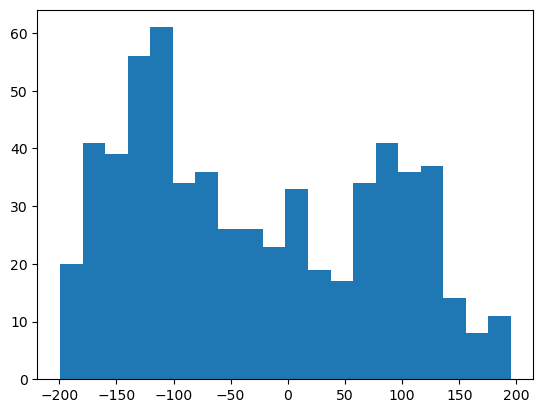

In [27]:
plt.hist(data['radial_velocity'], bins = 20)

In [28]:
from Payne import utils as payne_utils

c_kms = 2.99792458e5 # speed of light in km/s

def simulate_spec(interpolator, interp_wvl, wl, params):
    teff, logg, Z, rv = (params['teff'], params['logg'], params['z'], params['RV'])
    
    wl = wl * np.sqrt((1 - rv/c_kms)/(1 + rv/c_kms))
    
    return payne_utils.smoothing.smoothspec(wl, np.interp(wl, interp_wvl, interpolator( (teff, logg, Z, 0) )), resolution = 3000, smoothtype="R")

def continuum_normalize(wl, fl, ivar = None, avg_size = 150, ret_cont = False):
    
    fl_norm = np.zeros(np.size(fl))
    fl_cont = np.zeros(np.size(fl))
    
    ivar_yes = 0
    if ivar is not None:
        ivar_yes = 1
        ivar_norm = np.zeros(np.size(fl))
        
    for i in range(np.size(wl)):
        wl_clip = ((wl[i]-avg_size/2)<wl) * (wl<(wl[i]+avg_size/2))
        fl_cont[i] = np.median(fl[wl_clip])
        if ivar_yes:
            ivar_norm[i] = ivar[i]*np.median(fl[wl_clip])**2
    
    fl_norm = fl/fl_cont
    
    if ret_cont:
        if ivar_yes:
            return wl, fl_norm, ivar_norm, fl_cont
        else:
            return wl, fl_norm, fl_cont
    else:
        if ivar_yes:
            return wl, fl_norm, ivar_norm
        else:
            return wl, fl_norm

In [ ]:
ms_rv = []
ms_e_rv = []
redchis = []
drops = []

for i in tqdm(range(len(data))):
    try:
        spec = SDSS.get_spectra(plate=data['plate'][i], fiberID=data['fiberID'][i], mjd=data['mjd'][i])[0]
    
        wl = (10**spec[1].data['loglam'])
        fl = (spec[1].data['flux'])
        ivar = (spec[1].data['ivar'])
        
        wl, fl, ivar = continuum_normalize(wl, fl, ivar)
        
        mask = (4500 < wl)*(wl < 5500)
        
        rv, e_rv, redchi, init = msrvxc.fit.fit_rv(interp_bosz_norm, wvl, wl, fl, ivar, plot = False)
        
        redchis.append(redchi)
        ms_rv.append(rv)
        ms_e_rv.append(e_rv)
    except:
        drops.append(i)
    
    
    
data.remove_rows(drops)

  0%|                                                                                           | 0/612 [00:00<?, ?it/s]/home/arseneau/anaconda3/lib/python3.9/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
  0%|▏                                                                                | 1/612 [00:08<1:24:35,  8.31s/it]

0.26531552656507373
-30.956068851541296
15246.44791762354


  0%|▎                                                                                | 2/612 [00:19<1:42:25, 10.07s/it]

0.4544368368855
6.02997559187007
8958.872493393754


  0%|▍                                                                                | 3/612 [00:28<1:38:05,  9.66s/it]

0.5570068347726522
-110.84169972218416
31588.07859352158


  1%|▌                                                                                | 4/612 [00:38<1:38:24,  9.71s/it]

0.24915858123690768
-50.85745507439258
24964.152191844245


  1%|▋                                                                                | 5/612 [00:48<1:39:58,  9.88s/it]

0.09975769279759479
-16.72849194013946
8815.25180855084


  1%|▊                                                                                | 6/612 [00:57<1:37:24,  9.65s/it]

0.18019006133899607
-24.697399729683564
19459.6079371157


  1%|▉                                                                                | 7/612 [01:07<1:36:09,  9.54s/it]

0.3324812351292079
-17.841394477473003
26036.821153953962


  1%|█                                                                                | 8/612 [01:16<1:34:47,  9.42s/it]

0.2416724671253201
-37.1675904607086
14806.301247258581


  1%|█▏                                                                               | 9/612 [01:25<1:32:41,  9.22s/it]

0.5319664785740184
-52.45674102800518
26797.11932951465


  2%|█▎                                                                              | 10/612 [01:34<1:33:17,  9.30s/it]

0.13647801808608623
-13.420131717683933
13271.849337135052


  2%|█▍                                                                              | 11/612 [01:42<1:27:15,  8.71s/it]

0.19112051598280658
-13.112033033796166
12395.812799390495


  2%|█▌                                                                              | 12/612 [01:52<1:33:36,  9.36s/it]

0.1443118312947543
-28.654875090514572
10763.009005454242


  2%|█▋                                                                              | 13/612 [02:04<1:39:53, 10.01s/it]

0.444332077735291
-69.35175335084878
18607.142175940662


  2%|█▊                                                                              | 14/612 [02:10<1:28:35,  8.89s/it]

0.12037430757030639
-3.6059448441653323
6206.168153498444


  2%|█▉                                                                              | 15/612 [02:20<1:32:23,  9.29s/it]

0.4667605100530093
-13.838664991336245
22995.14879571973


  3%|██                                                                              | 16/612 [02:29<1:29:02,  8.96s/it]

0.6622891349993912
-28.904725877444097
18085.58426611934


  3%|██▏                                                                             | 17/612 [02:38<1:28:37,  8.94s/it]

0.38415117317283415
-106.1695983592714
24201.74927498671


  3%|██▎                                                                             | 18/612 [02:46<1:27:35,  8.85s/it]

0.20170471706489998
-22.78694348462544
13103.473609296507


  3%|██▍                                                                             | 19/612 [02:55<1:26:58,  8.80s/it]

0.5524791092544478
24.77949891640416
9449.758731004307


  3%|██▌                                                                             | 20/612 [03:01<1:19:41,  8.08s/it]

1.0908162170059832
-233.64702855826368
33502.137665628485


  3%|██▋                                                                             | 21/612 [03:10<1:22:44,  8.40s/it]

0.5473986512858143
-138.86947411331698
22003.097416634246


  4%|██▉                                                                             | 22/612 [03:20<1:25:02,  8.65s/it]

1.3182380352863416
-249.52590427781297
31820.149343023928


  4%|███                                                                             | 23/612 [03:27<1:20:29,  8.20s/it]

2.071688908228095
-428.400095263195
57672.483045463276


  4%|███▏                                                                            | 24/612 [03:36<1:24:32,  8.63s/it]

3.3048887447586726
-426.02025008734563
61355.16397933185


  4%|███▎                                                                            | 25/612 [03:45<1:23:23,  8.52s/it]

1.050516559827109
-237.54579736062223
28833.279172833176


  4%|███▍                                                                            | 26/612 [03:53<1:24:06,  8.61s/it]

0.41097744628723115
-148.98836304257688
27889.09531045234


  4%|███▌                                                                            | 27/612 [04:02<1:25:06,  8.73s/it]

0.29716715089370854
-71.79782637428764
12599.005628093879


  5%|███▋                                                                            | 28/612 [04:12<1:28:32,  9.10s/it]

1.0245446430100837
-230.4584691308445
27446.355457312406


  5%|███▊                                                                            | 29/612 [04:22<1:29:22,  9.20s/it]

1.3451465272877254
-205.41123546095045
23696.69890028893


  5%|███▉                                                                            | 30/612 [04:32<1:32:13,  9.51s/it]

1.472815608996567
-226.9245335587525
27357.58935063052


  5%|████                                                                            | 31/612 [04:42<1:32:42,  9.57s/it]

1.6351286845517268
63.17170488516703
27568.432523157193


  5%|████▏                                                                           | 32/612 [04:50<1:29:28,  9.26s/it]

1.4964854966620509
56.356187965992376
25349.731252429825


  5%|████▎                                                                           | 33/612 [05:00<1:29:45,  9.30s/it]

0.7203195407275226
-6.167204607935251
11788.633139906242


  6%|████▍                                                                           | 34/612 [05:08<1:25:47,  8.90s/it]

1.686793439475779
-258.8174831812374
31256.970499494357


  6%|████▌                                                                           | 35/612 [05:15<1:21:40,  8.49s/it]

1.9443941415432509
776.8689380902188
134418.5745298171


  6%|████▋                                                                           | 36/612 [05:23<1:18:30,  8.18s/it]

0.07411486144724848
15.483939969722897
4527.532287050164


  6%|████▊                                                                           | 37/612 [05:31<1:18:07,  8.15s/it]

0.2108546756005489
15.999901160871906
4671.9307181204995


  6%|████▉                                                                           | 38/612 [05:39<1:18:09,  8.17s/it]

0.9428378569555605
96.3092098723448
15310.691204802268


  6%|█████                                                                           | 39/612 [05:45<1:12:25,  7.58s/it]

0.7752129721865846
-17.75854740654769
11192.539308821582


  7%|█████▏                                                                          | 40/612 [05:54<1:16:14,  8.00s/it]

0.26342504550575496
-103.42284173697563
17081.024040895707


  7%|█████▎                                                                          | 41/612 [06:06<1:26:46,  9.12s/it]

3.170338818786898
153.55807897887965
68488.48491648138


  7%|█████▍                                                                          | 42/612 [06:14<1:23:57,  8.84s/it]

1.9397434791290349
33.17874786051563
25788.241398081835


  7%|█████▌                                                                          | 43/612 [06:22<1:20:17,  8.47s/it]

0.3615443284300912
-20.48459202717147
8095.527543075718


  7%|█████▊                                                                          | 44/612 [06:28<1:13:37,  7.78s/it]

0.5871769461234758
238.64379779798546
42349.59990199181


  7%|█████▉                                                                          | 45/612 [06:37<1:18:18,  8.29s/it]

0.7249036652344438
-60.87983658605077
17643.76830854886


  8%|██████                                                                          | 46/612 [06:44<1:12:29,  7.69s/it]

0.6100026178663741
211.1680940917539
29438.791372228072


  8%|██████▏                                                                         | 47/612 [06:52<1:15:30,  8.02s/it]

1.2907427098508315
-112.65561915709071
25024.654085398957


  8%|██████▎                                                                         | 48/612 [07:02<1:20:34,  8.57s/it]

0.4082517108406966
-71.03633429394725
10456.018477499994


  8%|██████▍                                                                         | 49/612 [07:11<1:20:29,  8.58s/it]

0.7612969251861315
61.23299062057407
12646.692663150267


  8%|██████▌                                                                         | 50/612 [07:18<1:17:12,  8.24s/it]

0.49882177300662667
185.19755502540804
27619.13593850425


  8%|██████▋                                                                         | 51/612 [07:29<1:25:06,  9.10s/it]

0.7246627570193396
205.41801250839455
25326.09950560612


  8%|██████▊                                                                         | 52/612 [07:39<1:26:33,  9.27s/it]

1.1333516125274508
323.98834633945006
38587.97190938929


  9%|██████▉                                                                         | 53/612 [07:56<1:46:39, 11.45s/it]

3.739316860253164
94.65249295172069
48093.88188083023


  9%|███████                                                                         | 54/612 [08:08<1:48:51, 11.71s/it]

2.221544894969272
42.95826803544786
29306.9238122206


  9%|███████▏                                                                        | 55/612 [08:19<1:47:22, 11.57s/it]

0.5569617605238135
-127.03917503424911
22196.46074949044


  9%|███████▎                                                                        | 56/612 [08:31<1:46:41, 11.51s/it]

1.207695610220176
277.22147289025526
35983.899345503894


  9%|███████▍                                                                        | 57/612 [08:39<1:37:33, 10.55s/it]

1.0195324096593288
322.3175713246031
42499.38391508317


  9%|███████▌                                                                        | 58/612 [08:46<1:27:04,  9.43s/it]

0.6862094646716803
209.37160644567373
27741.207292925403


 10%|███████▋                                                                        | 59/612 [08:55<1:25:25,  9.27s/it]

0.7638414243026521
-111.19248210269326
21423.105916605575


 10%|███████▊                                                                        | 60/612 [09:05<1:28:57,  9.67s/it]

0.6581163397457606
7.750056086112038
11080.146395596943


In [ ]:
print(len(ms_rv))

In [ ]:
def linear(x):
    return x

plt.figure(figsize=(8,8))
#plt.style.use('stefan.mplstyle')

plt.errorbar(ms_rv, data['radial_velocity'], xerr = ms_e_rv, yerr = data['radial_velocity_error'],
             fmt='o', label = 'Data', color='black', ecolor = 'teal')
plt.plot(ms_rv, linear(ms_rv), color = 'black')

#plt.text(50, -20, 'MAE = {:2.1f} km/s'.format(mae))
#plt.text(50, -40, 'Bias = {:2.1f} km/s'.format(bias))

ymin, ymax = plt.ylim()
plt.xlabel(r'RV (Crosscorrelation) $[km/s]$')
plt.ylabel(r'RV (Gaia) $[km/s]$')

In [ ]:
rmse = 0
mae = 0
for i in range(len(data['radial_velocity'])):
    rmse += (data['radial_velocity'][i] - ms_rv[i])**2
    mae += np.abs(data['radial_velocity'][i] - ms_rv[i])
    
rmse = np.sqrt( rmse / len(data['radial_velocity']))
mae = mae / len(data['radial_velocity'])
bias = np.average(data['radial_velocity'] - ms_rv)

print('rmse: {:2.1f} km/s'.format(rmse))
print('mae: {:2.1f} km/s'.format(mae))
print('bias: {:2.1f} km/s'.format(bias))

In [ ]:
from scipy.stats import norm
from statistics import NormalDist

t_err = np.sqrt(np.array(ms_e_rv)**2 + 10**2)

tdat = (data['radial_velocity'] - np.array(ms_rv)) / np.sqrt(data['radial_velocity_error']**2 + np.array(ms_e_rv)**2)
tdat2 = (data['radial_velocity'] - np.array(ms_rv)) / np.sqrt(data['radial_velocity_error']**2 + np.array(t_err)**2)

print( (np.quantile(tdat2, 0.84) - np.quantile(tdat2, 0.16)) / 2)

def gaussian(amp, sigma, mu, x):
    return amp*(1 / (sigma * np.sqrt(2 * np.pi)))*np.exp(-0.5*((x-mu)/sigma)**2)

datums = np.array((data['radial_velocity'] - np.array(ms_rv)) / np.sqrt(data['radial_velocity_error']**2 + np.array(ms_e_rv)**2))

#popt, pcov = scipy.optimize.curve_fit(gaussian, datums)


mu, sigma = norm.fit(datums)
print(mu, sigma)

x = np.linspace(np.quantile(datums, 0.16), np.quantile(datums, 0.84), 100)
y = gaussian(230, 1, -0.510, x)

#y = mlab.normpdf( 20, mu, sigma)
aaa = plt.hist(datums, bins = 20)
plt.plot(x, y)

a = aaa[1]
b = aaa[0]

print(len(a))
print(len(b))
#plt.scatter(a, b)

print(aaa[0])
#plt.scatter(datums, gaussian(sigma, mu, datums), c = 'b')

In [ ]:
i = 0

spec = SDSS.get_spectra(plate=data['plate'][i], fiberID=data['fiberID'][i], mjd=data['mjd'][i])[0]

wl = (10**spec[1].data['loglam'])
fl = (spec[1].data['flux'])
ivar = (spec[1].data['ivar'])

wl, fl, ivar = continuum_normalize(wl, fl, ivar)

mask = (4500 < wl)*(wl < 5500)

rv, e_rv, redchi, res = msrvxc.fit.fit_rv(interp_bosz_norm, wvl, wl, fl, ivar, plot = False)

print("RV: {:3.1f} \n Teff: {:4f} \n logg {:2.3f}".format(rv, res.params['teff'].value, res.params['logg'].value))
print(res.params['RV'])

In [ ]:
cutoff = 1
t_cc = np.interp(rv, rvgrid, cc)
temp = np.array([(cc[i] - t_cc) < cutoff for i in range(len(cc))])

In [ ]:
plt.figure(figsize = (10,5))
pcoef = np.polyfit(rvgrid, cc, 2)
plt.plot(rvgrid, cc)
plt.plot(rvgrid[temp], cc[temp])

In [ ]:
print(np.abs(min(rvgrid[temp]) -max(rvgrid[temp])) / 2)

In [ ]:
new_param_grid = np.array(param_grid).T
tmask = ~np.all([new_param_grid[-2] < -1500, new_param_grid[-2] > -1500], axis = 0)

print(np.std(new_param_grid[-2]))

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.hist(new_param_grid[-2], bins = 10)
plt.axvline(x = rv, c = 'black')
plt.axvline(x = rv + e_rv, c = 'black')
plt.axvline(x = rv - e_rv, c = 'black')
plt.xlabel('rv')
         
plt.subplot(1,3,2)
plt.hist(new_param_grid[0])
plt.xlabel('Teff')
         
plt.subplot(1,3,3)
plt.hist(new_param_grid[1])
plt.xlabel('logg')

In [ ]:
print(param_grid[3])

In [ ]:
plt.hist()

In [ ]:
plt.figure(figsize = (15,5))

#plt.subplot(1,2,1)

res.params['RV'].value = rv

plt.plot(wl[mask], msrvxc.utils.continuum_normalize(wl, fl)[1][mask], label = 'Observed')
plt.plot(wl[mask], simulate_spec(interp_bosz_norm, wvl, wl, res.params)[mask], alpha = 1, label = 'Model')

plt.legend()

#plt.subplot(1,2,2)
#
#plt.scatter(rvgrid, cc, s = 1)
#plt.axvline(x=data['radial_velocity'][i])
#
#plt.xlabel('RV')
#plt.ylabel('chi2')

In [ ]:
plt.figure(figsize = (15,5))

mask = (4500 < wl)*(wl < 5500)

plt.plot(wl[mask], msrvxc.utils.continuum_normalize(wl, fl)[1][mask], label = 'Observed')
plt.plot(wl[mask], simulate_spec(interp_bosz_norm, wvl, wl, res.params)[mask], alpha = 1, label = 'Model')

res.params['RV'].value = -348.5674

print(res.params)

#plt.plot(wl[mask], simulate_spec(interp_bosz_norm, wvl, wl, res.params)[mask], alpha = 1, label = 'Model With RV Forced Correct')

plt.legend()